In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install coreferee
!pip install fastcoref
!python3 -m coreferee install en
!python3 -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 7.2 MB/s 
     |████████████████████████████████| 7.6 MB 45.9 MB/s 
     |████████████████████████████████| 163 kB 74.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 10.2 MB/s 
     |████████████████████████████████| 115 kB 73.1 MB/s 
     |████████████████████████████████| 212 kB 71.3 MB/s 
     |████████████████████████████████| 127 kB 73.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65.4 MB 185 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for coreferee-model-en: filename=coreferee_model_en-1.0.0-py3-none-any.whl size=65422554 sha256=919bceb36c304e6a2a39624904867986c7b1a64efcd25cd53c67558659229e8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-acx9fr8i/wheels/6e/4d/40/0c67c4a6f34ccd20509fd0a10b702f6a3b2acb6f48e80fbf1f
Successfully built coreferee-model-en
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 9.5 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
import re
import coreferee
from typing import List,Tuple
import json
import pandas as pd 
import spacy
from spacy import Language, util
from spacy.tokens import Doc, Span
from transformers import pipeline
import time
import string
from fastcoref import FCoref

In [4]:
def extract_triplets(text: str) -> List[str]:
    """
    parses the text to triplets
    1. Split the text into tokens
    2. If the token is <triplet>, <subj>, or <obj>, then set the current variable to the appropriate value
    3. If the token is not one of the above, then append it to the appropriate variable
    4. If the current variable is <subj>, then append the triplet to the list of triplets
    :param text: str - the text to be parsed
    :type text: str
    :return: A list of dictionaries.
    """
    triplets = []
    relation, subject, relation, object_ = "", "", "", ""
    text = text.strip()
    current = "x"
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = "t"
            if relation != "":
                triplets.append(
                    {"head": subject.strip(), "type": relation.strip(), "tail": object_.strip()}
                )
                relation = ""
            subject = ""
        elif token == "<subj>":
            current = "s"
            if relation != "":
                triplets.append(
                    {"head": subject.strip(), "type": relation.strip(), "tail": object_.strip()}
                )
            object_ = ""
        elif token == "<obj>":
            current = "o"
            relation = ""
        else:
            if current == "t":
                subject += " " + token
            elif current == "s":
                object_ += " " + token
            elif current == "o":
                relation += " " + token
    if subject != "" and relation != "" and object_ != "":
        triplets.append(
            {"head": subject.strip(), "type": relation.strip(), "tail": object_.strip()}
        )

    return triplets


In [5]:


@Language.factory(
    "rebel",
    requires=["doc.sents"],
    assigns=["doc._.rel"],
    default_config={
        "model_name": "Babelscape/rebel-large",
        "device": 0,
    },
)
class RebelComponent:
    def __init__(
        self,
        nlp,
        name,
        model_name: str,
        device: int,
    ):
        assert model_name is not None, ""
        self.triplet_extractor = pipeline(
            "text2text-generation", model=model_name, tokenizer=model_name, device=device
        )
        # Register custom extension on the Doc
        if not Doc.has_extension("rel"):
            Doc.set_extension("rel", default={})

    def _generate_triplets(self, sents: List[Span]) -> List[List[dict]]:
        """
        1. We pass the text of the sentence to the triplet extractor.
        2. The triplet extractor returns a list of dictionaries.
        3. We extract the token ids from the dictionaries.
        4. We decode the token ids into text.
        5. We extract the triplets from the text.
        6. We return the triplets.
        The triplet extractor is a model that takes a sentence as input and returns a list of dictionaries.
        Each dictionary contains the token ids of the extracted triplets.
        The token ids are the numbers that represent the words in the sentence.
        For example, the token id of the word "the" is 2.
        The token ids are decoded into text using the tokenizer.
        The tokenizer is a model that takes a list of token ids as input and returns a list of words.
        :param sents: List[Span]
        :type sents: List[Span]
        :return: A list of lists of dicts.
        """
        output_ids = self.triplet_extractor(
            [sent.text for sent in sents], return_tensors=True, return_text=False
        )  # [0]["generated_token_ids"]
        extracted_texts = self.triplet_extractor.tokenizer.batch_decode(
            [out["generated_token_ids"] for out in output_ids]
        )
        extracted_triplets = []
        for text in extracted_texts:
            extracted_triplets.extend(extract_triplets(text))
        return extracted_triplets

    def set_annotations(self, doc: Doc, triplets: List[dict]):
        """
        The function takes a spacy Doc object and a list of triplets (dictionaries) as input.
        For each triplet, it finds the substring in the Doc object that matches the head and tail of the triplet.
        It then creates a spacy span object for each of the head and tail.
        Finally, it creates a dictionary of the relation type, head span and tail span and adds it to the Doc object
        :param doc: the spacy Doc object
        :type doc: Doc
        :param triplets: List[dict]
        :type triplets: List[dict]
        """
        for triplet in triplets:
            # get substring to spacy span
            head_span = re.search(triplet["head"], doc.text)
            tail_span = re.search(triplet["tail"], doc.text)
            # get spacy span
            if head_span is not None:
                head_span = doc.char_span(head_span.start(), head_span.end())
            else:
                #print(f"can't find spacy head span: {triplet['head']}")
                continue
                #head_span = triplet["head"]
            if tail_span is not None:
                tail_span = doc.char_span(tail_span.start(), tail_span.end())
            else:
                #print(f"can't find spacy tail span: {triplet['tail']}")
                continue
                #tail_span = triplet["tail"]
            
            if head_span is not None and tail_span is not None:
              offset = (head_span.start, tail_span.start)
              if offset not in doc._.rel:
                  doc._.rel[offset] = {
                      "relation": triplet["type"],
                      "head_span": head_span,
                      "tail_span": tail_span,
                  }

    def __call__(self, doc: Doc) -> Doc:
        """
        The function takes a doc object and returns a doc object
        :param doc: Doc
        :type doc: Doc
        :return: A Doc object with the sentence triplets added as annotations.
        """
        sentence_triplets = self._generate_triplets(doc.sents)
        self.set_annotations(doc, sentence_triplets)
        return doc

    def pipe(self, stream, batch_size=128):
        """
        It takes a stream of documents, and for each document,
        it generates a list of sentence triplets,
        and then sets the annotations for each sentence in the document
        :param stream: a generator of Doc objects
        :param batch_size: The number of documents to process at a time, defaults to 128 (optional)
        """
        for docs in util.minibatch(stream, size=batch_size):
            sents = []
            for doc in docs:
                sents += doc.sents
            sentence_triplets = self._generate_triplets(sents)
            index = 0
            for doc in docs:
                n_sent = len(list(doc.sents))
                self.set_annotations(doc, sentence_triplets[index : index + n_sent])
                index += n_sent
                yield doc



In [6]:
@Language.factory(
    "rebel_optimized",
    requires=["doc.sents"],
    assigns=["doc._.rel"],
    default_config={
        "model_name": "Babelscape/rebel-large",
        "device": 0,
    },
)
class OptimizedRebelComponent:
    def __init__(
        self,
        nlp,
        name,
        model_name: str,
        device: int,
    ):
        assert model_name is not None, ""
        self.triplet_extractor = pipeline(
            "text2text-generation", model=model_name, tokenizer=model_name, device=device
        )
        # Register custom extension on the Doc
        if not Doc.has_extension("rel"):
            Doc.set_extension("rel", default={})
    
    def _filter_sentences(self,sents:List[Span]) -> List[List[str]]:
        """"Filters a list of sentences returning only the ones containing multiple people as text"""
        sentences = []
        for sentence in sents:
            people = []
            for ent in sentence.ents:
                if ent.label_ == "PERSON" and ent.text not in people:
                    people.append(ent.text)
            if len(people) > 1:
                sentences.append(sentence.text)
        return sentences
            
    def _generate_triplets(self, sents: List[Span]) -> List[List[dict]]:
        """
        1. We pass the text of the sentence to the triplet extractor.
        2. The triplet extractor returns a list of dictionaries.
        3. We extract the token ids from the dictionaries.
        4. We decode the token ids into text.
        5. We extract the triplets from the text.
        6. We return the triplets.
        The triplet extractor is a model that takes a sentence as input and returns a list of dictionaries.
        Each dictionary contains the token ids of the extracted triplets.
        The token ids are the numbers that represent the words in the sentence.
        For example, the token id of the word "the" is 2.
        The token ids are decoded into text using the tokenizer.
        The tokenizer is a model that takes a list of token ids as input and returns a list of words.
        :param sents: List[Span]
        :type sents: List[Span]
        :return: A list of lists of dicts.
        """
        sentences = self._filter_sentences(sents)
        if len(sentences) == 0: return []
        output_ids = self.triplet_extractor(
            sentences, return_tensors=True, return_text=False
        )  # [0]["generated_token_ids"]
        extracted_texts = self.triplet_extractor.tokenizer.batch_decode(
            [out["generated_token_ids"] for out in output_ids]
        )
        extracted_triplets = []
        for text in extracted_texts:
            extracted_triplets.extend(extract_triplets(text))
        return extracted_triplets

    def set_annotations(self, doc: Doc, triplets: List[dict]):
        """
        The function takes a spacy Doc object and a list of triplets (dictionaries) as input.
        For each triplet, it finds the substring in the Doc object that matches the head and tail of the triplet.
        It then creates a spacy span object for each of the head and tail.
        Finally, it creates a dictionary of the relation type, head span and tail span and adds it to the Doc object
        :param doc: the spacy Doc object
        :type doc: Doc
        :param triplets: List[dict]
        :type triplets: List[dict]
        """
        for triplet in triplets:
            # get substring to spacy span
            head_span = re.search(triplet["head"], doc.text)
            tail_span = re.search(triplet["tail"], doc.text)
            # get spacy span
            if head_span is not None:
                head_span = doc.char_span(head_span.start(), head_span.end())
            else:
                #print(f"can't find spacy head span: {triplet['head']}")
                continue
                #head_span = triplet["head"]
            if tail_span is not None:
                tail_span = doc.char_span(tail_span.start(), tail_span.end())
            else:
                #print(f"can't find spacy tail span: {triplet['tail']}")
                continue
                #tail_span = triplet["tail"]
            
            if head_span is not None and tail_span is not None:
              offset = (head_span.start, tail_span.start)
              if offset not in doc._.rel:
                  doc._.rel[offset] = {
                      "relation": triplet["type"],
                      "head_span": head_span,
                      "tail_span": tail_span,
                  }

    def __call__(self, doc: Doc) -> Doc:
        """
        The function takes a doc object and returns a doc object
        :param doc: Doc
        :type doc: Doc
        :return: A Doc object with the sentence triplets added as annotations.
        """
        sentence_triplets = self._generate_triplets(doc.sents)
        self.set_annotations(doc, sentence_triplets)
        return doc

    def pipe(self, stream, batch_size=128):
        """
        It takes a stream of documents, and for each document,
        it generates a list of sentence triplets,
        and then sets the annotations for each sentence in the document
        :param stream: a generator of Doc objects
        :param batch_size: The number of documents to process at a time, defaults to 128 (optional)
        """
        
        for docs in util.minibatch(stream, size=batch_size):
            for doc in docs:
                sentence_triplets = self._generate_triplets(doc.sents)
                self.set_annotations(doc, sentence_triplets)
                yield doc



In [7]:

@Language.factory(
    "coref_resolver",
    assigns=["doc._.resolved_text"],
    default_config={
        "model_name": "FCoref",
        "device": "cuda:0",
    },
)
class CorefResolver:
    """a class that implements the logic from
    https://towardsdatascience.com/how-to-make-an-effective-coreference-resolution-model-55875d2b5f19"""
    def __init__(
        self,
        nlp,
        name,
        model_name: str,
        device: str,
    ):
        assert model_name is not None, ""
            
        self.coref_model = FCoref(device=device)
        # Register custom extension on the Doc
        if not Doc.has_extension("resolved_text"):
            Doc.set_extension("resolved_text", default=None)
    def get_span_noun_indices(self, doc: Doc, cluster: List[Tuple]) -> List[int]:
        """
        > Get the indices of the spans in the cluster that contain at least one noun or proper noun
        :param doc: Doc
        :param cluster: List[List[int]]
        :return: A list of indices of spans that contain at least one noun or proper noun.
        """
        spans = [doc.char_span(span[0],span[1]) for span in cluster]
        spans_pos = [[token.pos_ for token in span] for span in spans]
        span_noun_indices = [
            i for i, span_pos in enumerate(spans_pos) if any(pos in span_pos for pos in ["NOUN", "PROPN"])
        ]
        return span_noun_indices
    def get_cluster_head(self, doc: Doc, cluster: List[Tuple], noun_indices: List[int]):
        """
        > Given a spaCy Doc, a list of clusters, and a list of noun indices, return the head span and its start and end
        indices
        :param doc: the spaCy Doc object
        :type doc: Doc
        :param cluster: a list of lists, where each sublist is a span of tokens in the document
        :type cluster: List[List[int]]
        :param noun_indices: a list of indices of the nouns in the cluster
        :type noun_indices: List[int]
        :return: The head span and the start and end indices of the head span.
        """
        head_idx = noun_indices[0]
        head_start,head_end = cluster[head_idx]
        head_span = doc.char_span(head_start,head_end)
        return head_span, [head_start, head_end]
    def is_containing_other_spans(self,span: List[int], all_spans: List[List[int]]):
        """
        It returns True if there is any span in all_spans that is contained within span and is not equal to span
        :param span: the span we're checking to see if it contains other spans
        :type span: List[int]
        :param all_spans: a list of all the spans in the document
        :type all_spans: List[List[int]]
        :return: A list of all spans that are not contained in any other span.
        """
        return any([s[0] >= span[0] and s[1] <= span[1] and s != span for s in all_spans])
    def core_logic_part(self,document: Doc, coref: List[int], resolved: List[str], mention_span: Span):
        """
        If the last token of the mention is a possessive pronoun, then add an apostrophe and an s to the mention.
        Otherwise, just add the last token to the mention
        :param document: Doc object
        :type document: Doc
        :param coref: List[int]
        :param resolved: list of strings, where each string is a token in the sentence
        :param mention_span: The span of the mention that we want to replace
        :return: The resolved list is being returned.
        """
        char_span = document.char_span(coref[0],coref[1])
        final_token = char_span[-1]
        final_token_tag = str(final_token.tag_).lower()
        test_token_test = False
        for option in ["PRP$", "POS", "BEZ"]:
            if option.lower() in final_token_tag:
                test_token_test = True
                break
        if test_token_test:
            resolved[char_span.start] = mention_span.text + "'s" + final_token.whitespace_
        else:
            resolved[char_span.start] = mention_span.text + final_token.whitespace_
        for i in range(char_span.start + 1, char_span.end):
            resolved[i] = ""
        return resolved
    def _has_multiple_people(self,doc:Doc) -> bool:
        people = []
        for entity in doc.ents:
            if entity.label_ == 'PERSON' and entity.text not in people:
                people.append(entity.text)
            if len(people)>1:
                return True
        return False
    def __call__(self, doc: Doc) -> Doc:
        """
        The function takes a doc object and returns a doc object
        :param doc: Doc
        :type doc: Doc
        :return: A Doc object with the sentence triplets added as annotations.
        """
        preds = self.coref_model.predict(
                texts=[doc.text])
        clusters = preds[0].get_clusters(as_strings=False)
        resolved = list(tok.text_with_ws for tok in doc)
        cluster_heads = {}
        all_spans = [span for cluster in clusters for span in cluster]
        for cluster in clusters:
            indices = self.get_span_noun_indices(doc,cluster)
            if indices:
                mention_span, mention = self.get_cluster_head(doc, cluster, indices)
                cluster_heads[str(mention_span)] = mention

                for coref in cluster:
                    if coref != mention and not self.is_containing_other_spans(coref, all_spans):
                        self.core_logic_part(doc, coref, resolved, mention_span)
        doc._.resolved_text = "".join(resolved)
        return doc
    def pipe(self, stream, batch_size=512):
        for docs in util.minibatch(stream, size=batch_size):
            filtered_docs = [doc for doc in docs if self._has_multiple_people(doc)]
            preds = self.coref_model.predict(
                    texts=[doc.text for doc in filtered_docs],max_tokens_in_batch=512)
                    
            doc_keys = [doc.text[:15] for doc in filtered_docs]
            for pred in preds:
                clusters = pred.get_clusters(as_strings=False)
                doc = filtered_docs[doc_keys.index(pred.text[:15])] #Find document since preds returns random order
                resolved = list(tok.text_with_ws for tok in doc)
                cluster_heads = {}
                all_spans = [span for cluster in clusters for span in cluster]
                for cluster in clusters:
                    try:
                        indices = self.get_span_noun_indices(doc,cluster)
                        if indices:
                            mention_span, mention = self.get_cluster_head(doc, cluster, indices)
                            cluster_heads[str(mention_span)] = mention

                            for coref in cluster:
                                if coref != mention and not self.is_containing_other_spans(coref, all_spans):
                                    self.core_logic_part(doc, coref, resolved, mention_span)
                    except:
                        print("Couldn't process: ",doc.text[:15])
                
                        continue
                doc._.resolved_text = "".join(resolved)
                yield doc

In [8]:
def resolve_corefs(doc):
  s = set(["his","her","their"])
  mutable_doc = [str(word) for word in doc]
  if doc._.coref_chains:
    for chain in doc._.coref_chains.chains:
      #print(chain)
      for token in chain:
        #print(token)
        if len(token) == 1:
          coref = doc._.coref_chains.resolve(doc[token[0]])
          if coref:
            if len(coref) > 1:
              mutable_doc[token[0]] = " and ".join([str(word) for word in coref])
            else:
              t = str(doc[token[0]])
              c = str(coref[0])
              #print(t)
              if t in s:
                mutable_doc[token[0]] = f"{c}'s"
              else:
                mutable_doc[token[0]] = c
  output = ""
  cnt = 0
  for token in mutable_doc:
    if token not in string.punctuation and cnt>0:
      output+=f" {token}"
    else:
      output+=token
    cnt+=1
  return output

In [9]:

# Using readlines()
file1 = open('/content/drive/MyDrive/Text mining_Shared/enwiki20220701-stripped/AB/wiki_63', 'r')
Lines = file1.readlines()
  
content = []
count = 0
# Strips the newline character
for line in Lines:
    content.append(json.loads(line.split('\n')[0]))

In [10]:
df = pd.DataFrame(content)

In [11]:
df.head()

,id,revid,url,title,text
0,67248252,18087347,https://en.wikipedia.org/wiki?curid=67248252,Barragem de Idanha,
1,67248254,577301,https://en.wikipedia.org/wiki?curid=67248254,Cyclone Ola (2015),
2,67248256,11292982,https://en.wikipedia.org/wiki?curid=67248256,Romanian-Soviet split,
3,67248259,577301,https://en.wikipedia.org/wiki?curid=67248259,Cyclone Diamondra (2015),
4,67248260,10951369,https://en.wikipedia.org/wiki?curid=67248260,131 Houston Street,


In [12]:
df = df.loc[df['text']!= ""] # Discard empty pages
df = df.reset_index()
print(len(df))

51268


## Actual Pipeline

In [13]:
# preprocess = spacy.load("en_core_web_lg")
# preprocess.add_pipe('coreferee')
preprocess = spacy.load("en_core_web_lg")
preprocess.add_pipe("coref_resolver",config={'device':'cuda:0'})
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe("rebel_optimized",config={
    'device':0, # Number of the GPU, -1 if want to use CPU
    'model_name':'Babelscape/rebel-large'} # Model used, will default to 'Babelscape/rebel-large' if not given
    )

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/393 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/362M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/123 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344 [00:00<?, ?B/s]

In [14]:
#Only used with coreferee
def has_multiple_people(doc):
  people = []
  for entity in doc.ents:
    if entity.label_ == 'PERSON' and entity.text not in people:
      people.append(entity.text)
    if len(people)>1:
      return True
  return False

In [15]:
sample_df = df[:10]
sample_df

,index,id,revid,url,title,text
0,5,67248261,41840956,https://en.wikipedia.org/wiki?curid=67248261,Clepardia Kraków,"Clepardia Kraków (""KS Clepardia Kraków"") is a ..."
1,9,67248272,12809580,https://en.wikipedia.org/wiki?curid=67248272,Mason Duval,Mason Duval (born 24 August 2001) is a Caymani...
2,15,67248291,754619,https://en.wikipedia.org/wiki?curid=67248291,Metamorfosi railway station,Metamorfosi railway station () is a station on...
3,21,67248312,754619,https://en.wikipedia.org/wiki?curid=67248312,"3rd Battalion, Yorkshire Volunteers","The 3rd Battalion (West Yorkshire), Yorkshire ..."
4,29,67248329,3311318,https://en.wikipedia.org/wiki?curid=67248329,Mawa Gare,Mawa Gare (Mawa Station) is a village in the B...
5,32,67248338,32849731,https://en.wikipedia.org/wiki?curid=67248338,Meyn,Meyn may refer to:
6,42,67248360,293907,https://en.wikipedia.org/wiki?curid=67248360,Ellen Hope Hays,"Ellen Hope Hays (December 29, 1927 - October 8..."
7,56,67248405,237572,https://en.wikipedia.org/wiki?curid=67248405,Portia Gage,"Portia Gage (March 15, 1813 - February 23, 190..."
8,57,67248407,125972,https://en.wikipedia.org/wiki?curid=67248407,Amy Vine,Amy Joy Vine (born 22 December 1991) is an Aus...
9,67,67248425,206485,https://en.wikipedia.org/wiki?curid=67248425,1959 Mississippi Southern Southerners football...,The 1959 Mississippi Southern Southerners foot...


In [43]:
import math


def is_first_batch(batch_counter):
  if batch_counter>0:
      return False
  return True

def cast_rel_dict(rel_dict):
  return {"head": str(rel_dict["head_span"]), "relation": rel_dict["relation"], "tail": str(rel_dict["tail_span"])}

## New implementation
RELATIONSHIPS = {'spouse','sibling','father','child','family','mother','relative','student of'} #set
BATCH_SIZE = 512 # Colab usually breaks with higher batch sizes.
NUM_BATCHES = math.ceil(len(sample_df)/BATCH_SIZE)

print(NUM_BATCHES)

for batch in range(0,NUM_BATCHES):
    print("Processing batch: ",batch)
    start = time.time()
    texts = sample_df.iloc[batch*BATCH_SIZE:min((batch+1)*BATCH_SIZE,len(sample_df))]["text"].values
    docs = preprocess.pipe(texts,batch_size=BATCH_SIZE) 
    prepped_texts = [doc._.resolved_text for doc in docs]
    #prepped_texts = [resolve_corefs(doc) for doc in docs if has_multiple_people(doc)]
    
    print(f"Resolving coreferences took {time.time() - start} seconds")
    start = time.time()
    docs = nlp.pipe(prepped_texts)
    relations = [{"doc_idx":idx,"relations": [cast_rel_dict(rel_dict) for _,rel_dict in doc._.rel.items() if rel_dict["relation"] in RELATIONSHIPS]} for idx,doc in enumerate(docs)]
    print(f"Relation extraction took {time.time() - start} seconds")
    pd.DataFrame(relations).to_csv("/content/drive/MyDrive/relations.csv",mode='a',index=False,header=is_first_batch(batch))

1
Processing batch:  0


  0%|          | 0/1 [00:00<?, ?ba/s]


5it [00:00, 52.26it/s]


Inference:   0%|          | 0/5 [00:00<?, ?it/s]

Resolving coreferences took 1.1096091270446777 seconds


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:1046: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


Relation extraction took 9.841349601745605 seconds


# Filter and close

In [51]:
df_filtered = pd.read_csv("/content/drive/MyDrive/relations.csv")

In [52]:
# Filter the names beginning with a lower case letter
df_filtered["relations"] = df_filtered["relations"].apply(lambda rels: [rel for rel in eval(rels) if rel["head"][0].isupper() and rel["tail"][0].isupper()] if rels != "" else [])
# Filter the names that consist of the upper case letter only
df_filtered["relations"] = df_filtered["relations"].apply(lambda rels: [rel for rel in rels if not rel["head"].isupper() and not rel["tail"].isupper()])
# Filter the names that consist of the lower case letter only
df_filtered["relations"] = df_filtered["relations"].apply(lambda rels: [rel for rel in rels if not rel["head"].islower() and not rel["tail"].islower()])
# Certain relations are symmetric. So, we need to add the reverse relation as well.
# For perfectly symmetric:
df_filtered["relations"] = df_filtered["relations"].apply(lambda rels: rels + [{"head":rel["tail"], "tail":rel["head"], "relation":rel["relation"]} for rel in rels if rel["relation"] in ["spouse","sibling","family","relative"]])
# For symmetric ones with non-trivial symmetry:
df_filtered["relations"] = df_filtered["relations"].apply(lambda rels: rels + [{"head":rel["tail"], "tail":rel["head"], "relation":"child"} for rel in rels if rel["relation"] in ["father","mother"]])
# Remove reflexive relations
df_filtered["relations"] = df_filtered["relations"].apply(lambda rels: [rel for rel in rels if  rel["head"] != rel["tail"]])
# Remove duplicates just in case
df_filtered["relations"] = df_filtered["relations"].apply(lambda rels: [dict(s) for s in set(frozenset(d.items()) for d in rels)])

df_filtered

,doc_idx,relations
0,0,"[{'head': 'Lucy Stone', 'tail': 'Henry Blackwe..."
1,1,[]
2,2,[]
3,3,[]
4,4,[]


In [53]:
df_filtered.to_csv("/content/drive/MyDrive/relations_filtered.csv")

# Save to the evaluation format

In [64]:
reformatted_df = pd.DataFrame(columns=["Text id", "Head", "Type", "Tail"])

for i in range(len(df_filtered)):
  for relation in df_filtered["relations"][i]:
    reformatted_df = reformatted_df.append({"Text id": df_filtered["doc_idx"][i], "Head": relation["head"], "Type": relation["relation"], "Tail": relation["tail"]}, ignore_index=True)

reformatted_df

,Text id,Head,Type,Tail
0,0,Lucy Stone,spouse,Henry Blackwell
1,0,Portia Gage,student of,Abbie Leavitt
2,0,Henry Blackwell,spouse,Lucy Stone
3,0,John Gage,spouse,Portia Gage
4,0,Portia Gage,spouse,John Gage


In [65]:
reformatted_df.to_csv("/content/drive/MyDrive/relations_reformatted.csv")

# Visualisation

In [27]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
test_vis = pd.read_csv(f"/content/drive/MyDrive/relations_filtered.csv")

[{'head': 'Portia Gage', 'relation': 'mother', 'tail': 'Portia Gage'},
 {'head': 'Portia Gage', 'relation': 'spouse', 'tail': 'John Gage'},
 {'head': 'John Gage', 'relation': 'spouse', 'tail': 'Portia Gage'},
 {'head': 'Portia Gage', 'relation': 'student of', 'tail': 'Abbie Leavitt'},
 {'head': 'Lucy Stone', 'relation': 'spouse', 'tail': 'Henry Blackwell'},
 {'head': 'Henry Blackwell', 'relation': 'spouse', 'tail': 'Lucy Stone'}]

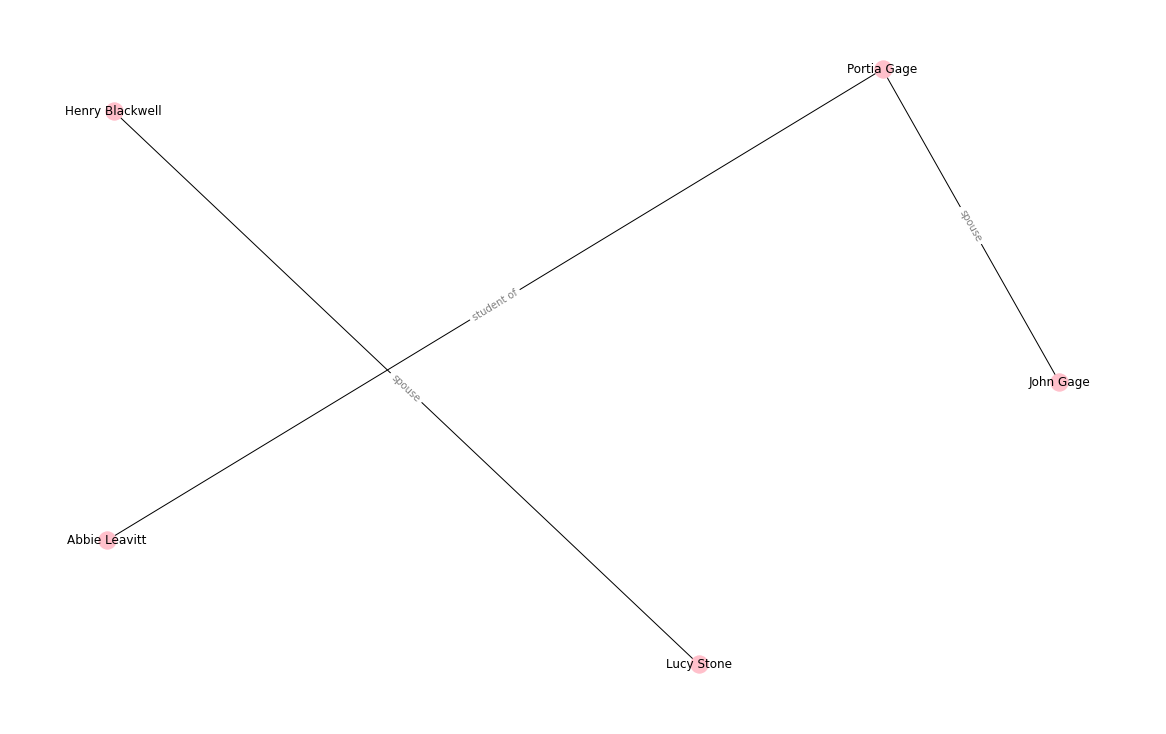

In [55]:
import matplotlib.pyplot as plt
import networkx as nx

edges = [(rel_dict['head'], rel_dict['tail']) for relations in test_vis["relations"] for rel_dict in eval(relations) if relations != ""]
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, k=5, scale=1.0)
plt.figure(figsize=(16, 10))
nx.draw(
    G,
    pos,
    edge_color='black',
    width=1,
    linewidths=1,
    node_color='pink',
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels={
        (rel_dict['head'], rel_dict['tail']): rel_dict['relation']
        for relations in test_vis["relations"] for rel_dict in eval(relations) if relations != ""
    },
    font_color='grey'
)
plt.axis('off')
plt.show()